# Helper for E2E 

In [24]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import IPython.display as ipd
import torchaudio
import torch
from torch.utils.data import DataLoader
from data import LibriDataset
import numpy as np
import torch.nn as nn
from data import CharacterTokenizer, LibriDataset
from model import CNNLayerNorm, ResidualCNN, BidirectionalGRU, SpeechRecognitionModel


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import warnings
warnings.filterwarnings('ignore')

## Audio

In [3]:
filename = "data/1089-134686-0000.flac"
waveform, sample_rate = torchaudio.load(filename)
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

Shape of waveform: torch.Size([1, 166960])
Sample rate of waveform: 16000


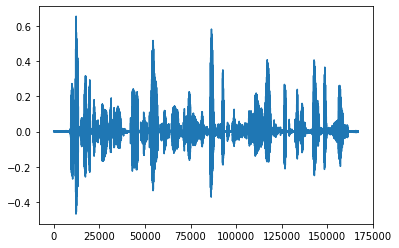

In [4]:
plt.figure()
plt.plot(waveform.t().numpy())

In [5]:
ipd.Audio(filename)

## Mel specgram

In [6]:
mel = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128)

In [7]:
waveform.shape[1]/mel.hop_length

834.8

In [8]:
spec = mel(waveform)

In [9]:
torch.max(spec[0])

tensor(357.8594)

Shape of spectrogram: torch.Size([1, 128, 835])


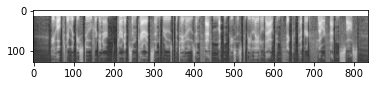

In [10]:
print("Shape of spectrogram: {}".format(spec.shape))
plt.figure()
plt.imshow(spec.log2()[0,:,:].numpy(), cmap='gray')

In [11]:
spec.log2()[0,:,:].shape

torch.Size([128, 835])

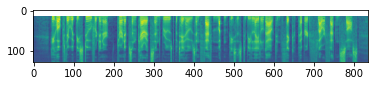

In [12]:
plt.imshow(spec.log2().squeeze(0))

In [13]:
randimg = torch.randn((1, 128, 1000))

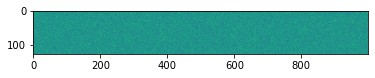

In [14]:
plt.imshow(randimg.squeeze(0))

## Spec augment

In [18]:
fm = torchaudio.transforms.FrequencyMasking(freq_mask_param=15)

In [16]:
tm = torchaudio.transforms.TimeMasking(time_mask_param=35)

In [17]:
freq = fm(spec)

In [19]:
freq.shape

torch.Size([1, 128, 835])

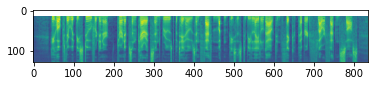

In [20]:
plt.imshow(freq.log2().squeeze(0))

In [21]:
time = tm(freq)

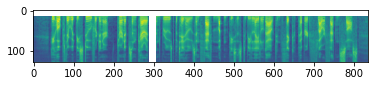

In [22]:
plt.imshow(time.log2().squeeze(0))

In [23]:
time.shape

torch.Size([1, 128, 835])

In [24]:
tf = nn.Sequential(mel,fm,tm)

In [25]:
specaug = tf(waveform)
specaug.shape

torch.Size([1, 128, 835])

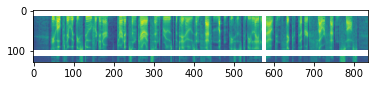

In [26]:
plt.imshow(specaug.log2().squeeze(0))

## Padding

In [27]:
print(randimg.shape, specaug.shape)
imgs = []
imgs.append(randimg.squeeze(0).transpose(0,1))
imgs.append(specaug.squeeze(0).transpose(0,1))
imgs.append(randimg.squeeze(0).transpose(0,1))

torch.Size([1, 128, 1000]) torch.Size([1, 128, 835])


In [28]:
imgs[0].shape

torch.Size([1000, 128])

In [30]:
paded = nn.utils.rnn.pad_sequence(imgs, batch_first=True)
paded.shape

torch.Size([3, 1000, 128])

## Datasets

### torchaudio default dataset

In [25]:
LIBRI_DIR = "/home/syl20/data/en/librispeech"
print(LIBRI_DIR)
ds = torchaudio.datasets.LIBRISPEECH(LIBRI_DIR, url="test-clean", download=False)
print(len(ds))
# format: (waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id)
print(ds[0])

/home/syl20/data/en/librispeech
2620
(tensor([[0.0003, 0.0003, 0.0004,  ..., 0.0021, 0.0021, 0.0016]]), 16000, 'HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOUR FATTENED SAUCE', 1089, 134686, 0)


In [26]:
ds[0][0].shape

torch.Size([1, 166960])

### custom dataset with collate_fn for padding

In [27]:
LIBRI_DIR = "/home/syl20/data/en/librispeech"
mspec = torchaudio.transforms.MelSpectrogram()
spec_aug = nn.Sequential(
        torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
        torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
        torchaudio.transforms.TimeMasking(time_mask_param=35)
)
ds = LibriDataset(LIBRI_DIR, CharacterTokenizer, dataset="test-clean", transform=mspec)
ds[0][0].shape

torch.Size([1, 128, 835])

In [29]:
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6,
          'collate_fn':ds.collate}

dl = DataLoader(ds, **params)

In [38]:
# torch expects input of same size => use collate_fn
i = iter(dl)
sample = next(i)
# X: (batch, channel, n_feat, n_frames) Y: (batch, n_chars)
print(sample[0].shape, sample[1].shape)
print("in len: ", sample[2])
print("out len: ", sample[3])
print(len(sample[2]), len(sample[3]))

torch.Size([64, 1, 128, 2262]) torch.Size([64, 417])
in len:  [435, 1013, 666, 879, 1110, 781, 482, 427, 887, 619, 1045, 349, 415, 384, 683, 169, 260, 996, 564, 178, 1242, 700, 802, 457, 498, 427, 1052, 373, 301, 711, 500, 225, 569, 716, 1881, 355, 971, 618, 560, 455, 391, 2262, 344, 1594, 284, 605, 318, 343, 309, 778, 283, 1223, 348, 205, 287, 317, 1117, 1526, 996, 849, 949, 392, 456, 1637]
out len:  [74, 156, 113, 174, 210, 171, 96, 82, 156, 99, 195, 84, 101, 75, 130, 24, 41, 211, 136, 40, 213, 103, 135, 51, 101, 85, 206, 84, 55, 125, 98, 26, 103, 141, 250, 58, 163, 110, 86, 88, 80, 417, 70, 275, 31, 81, 64, 53, 39, 153, 58, 219, 63, 30, 55, 61, 226, 266, 207, 203, 188, 65, 103, 271]
64 64


In [45]:
l_dl = len(dl)
l_ds = len(ds)
print(l_ds / params['batch_size'], l_dl)

40.9375 41


## Model

In [43]:
x = sample[0]
y = sample[1]
print(x.shape, y.shape)

torch.Size([64, 1, 128, 2262]) torch.Size([64, 417])


### Layer normalization (n_batch, n_channels, n_feats, n_frames) => (n_batch, n_channels, n_feats, n_frames)

In [51]:
 cnn = CNNLayerNorm(128)
 cnned = cnn(x)
 print(cnned.shape)

torch.Size([64, 1, 128, 2093])


torch.Size([128, 2093])


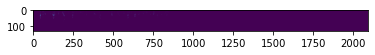

In [67]:
print(x[0].squeeze(0).shape)
plt.imshow(x[0].squeeze(0))

In [66]:
cnned[0].squeeze(0).shape

torch.Size([128, 2093])

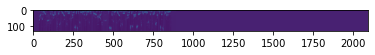

In [74]:
plt.imshow(cnned[0].detach().numpy().squeeze(0))

### Conv2d (n_batch, n_channel, n_feat, n_frameas) => (n_batch, 32, n_feat/2, n_frames/2)

In [81]:
# (in,out,kernel_size)
conv = nn.Conv2d(1, 32, 3, stride=2, padding=3//2)

In [91]:
print(x[0].shape)
print(x.unsqueeze(0)[0].shape)
conved = conv(x.unsqueeze(0)[0])
print(conved.shape)

torch.Size([1, 128, 2093])
torch.Size([64, 1, 128, 2093])
torch.Size([64, 32, 64, 1047])


In [97]:
from mpl_toolkits.mplot3d import Axes3D
x = conved[0].squeeze(0).detach().numpy()
# Axes3D.plot(x[])


In [107]:
res = ResidualCNN(32, 32, kernel=3, stride=1, dropout=0.1, n_feats=64)
print(conved.shape)
resed = res(conved)
print(resed.shape)


torch.Size([64, 32, 64, 1047])
torch.Size([64, 32, 64, 1047])


### Bidirectional GRU

In [130]:

sizes = resed.shape
print(sizes)
resed_3 = resed.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
print(resed_3.shape)
resed_3 = resed_3.transpose(1, 2)  # (batch, time, feature)
print(resed_3.shape)
fc_in_dim = int((128/2)*32)
fc = nn.Linear(fc_in_dim, 512)
fced = fc(resed_3)

torch.Size([64, 32, 64, 1047])
torch.Size([64, 2048, 1047])
torch.Size([64, 1047, 2048])


In [132]:
rnn_dim, hidden_size = 512, 512
dropout = 0.1
batch_first = True
bi = BidirectionalGRU(rnn_dim, hidden_size, dropout, batch_first)
print(fced.shape)
bied = bi(fced)
print(bied.shape)


torch.Size([64, 1047, 512])
torch.Size([64, 1047, 1024])


In [19]:
hparams = {
        "n_cnn_layers": 3,
        "n_rnn_layers": 5,
        "rnn_dim": 512,
        "n_class": 29,
        "n_feats": 128,
        "stride":2,
        "dropout": 0.1,
        "learning_rate": 0.0005,
        "batch_size": 20,
        "epochs": 10
    }

model = SpeechRecognitionModel(
        hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
        hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
        )

In [44]:
print(x.shape, y.shape)
out = model(x)
print(out.shape)

torch.Size([64, 1, 128, 2262]) torch.Size([64, 417])
torch.Size([64, 1131, 29])


In [136]:
print(y.shape)

torch.Size([64, 1047, 29])


In [9]:
tutu = torch.rand(2,3,4)
print(tutu)
print(tutu[0,0,0])


tensor([[[0.7040, 0.0438, 0.6831, 0.1319],
         [0.4867, 0.9101, 0.4552, 0.2420],
         [0.9021, 0.6214, 0.5377, 0.1399]],

        [[0.2510, 0.9852, 0.5626, 0.4604],
         [0.1031, 0.9983, 0.3350, 0.6904],
         [0.6387, 0.2667, 0.5424, 0.5784]]])
tensor(0.7040)


In [18]:
print(y.shape)

NameError: name 'y' is not defined

## CTC testing

In [52]:
I = 50 # input seq length
C = 20 # output classes
N = 16 # batch
O = 30 # output seq length
O_min = 10
input = torch.randn(T, N, C).log_softmax(2).detach().requires_grad_()
print(input.shape)
target = torch.randint(low=1, high=C, size=(N, O), dtype=torch.long)
print(target.shape)
input_lengths = torch.full(size=(N,), fill_value=I, dtype=torch.long)
target_lengths = torch.randint(low=O_min, high=O, size=(N,), dtype=torch.long)

torch.Size([50, 16, 20])
torch.Size([16, 30])
